In [1]:
import numpy as np
import pandas as pd
import math

import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate
import tifffile

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

import os

import scipy

2023-04-08 19:00:26.311329: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-08 19:00:27.226339: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/amazon/efa/lib:/opt/amazon/openmpi/lib:/usr/local/cuda/efa/lib:/usr/local/cuda/lib:/usr/local/cuda:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/targets/x86_64-linux/lib:/usr/local/lib:/usr/lib:/opt/amazon/efa/lib:/opt/amazon/openmpi/lib:/usr/local/cuda/efa/lib:/usr/local/cuda/lib:/usr/local/cuda:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cud

In [2]:
tiles = pd.read_csv(r'Data/Tiles_expanded_road_vector.csv')
tiles = tiles.drop(['Unnamed: 0'], axis = 1)

In [3]:
tiles.head(5)

,Tile_ID,Long2,Lat2,Long1,Lat1,Mid_lat,Mid_long,Stop_Signs,Paving_historical,Paving_future,Bus_stop,Collisions_Future,Collisions_Historical,RTTYP
0,36,-122.514446,37.779636,-122.513306,37.778732,37.779184,-122.513876,0.0,0.0,0.0,0.0,0.0,0.0,M
1,37,-122.514446,37.778732,-122.513306,37.777829,37.778280,-122.513876,0.0,0.0,0.0,0.0,0.0,0.0,M
2,151,-122.513306,37.779636,-122.512166,37.778732,37.779184,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,M
3,152,-122.513306,37.778732,-122.512166,37.777829,37.778280,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,M
4,153,-122.513306,37.777829,-122.512166,37.776925,37.777377,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,M


In [4]:
tiles = pd.get_dummies(tiles, columns = ['RTTYP'])

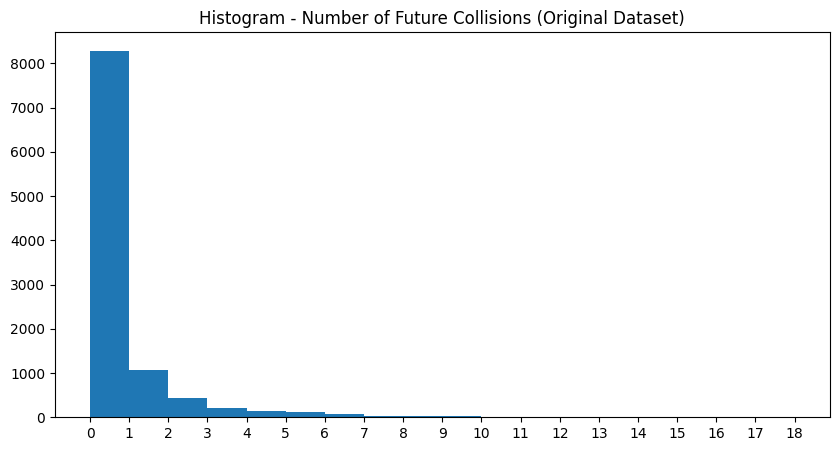

In [5]:
fig, ax = plt.subplots(figsize =(10, 5))
labels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18]
ax.hist(tiles['Collisions_Future'], bins = labels)
ax.set_xticks(labels)
plt.title('Histogram - Number of Future Collisions (Original Dataset)')
 
# Show plot
plt.show()

**Balanced Set 1: Downsample 0 collision tiles**

In [6]:
count_1 = len(tiles[tiles["Collisions_Future"] == 1])
count_1

1060

In [7]:
from sklearn.utils import resample

sample = tiles[tiles["Collisions_Future"] > 0]
set_0 = tiles[tiles["Collisions_Future"] == 0]
sample_0 = resample(set_0, replace=False, n_samples= count_1)
sample = pd.concat([sample, sample_0])

In [8]:
sample.head(5)

,Tile_ID,Long2,Lat2,Long1,Lat1,Mid_lat,Mid_long,Stop_Signs,Paving_historical,Paving_future,Bus_stop,Collisions_Future,Collisions_Historical,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U
10,266,-122.512166,37.779636,-122.511026,37.778732,37.779184,-122.511596,1.0,0.0,0.0,0.0,5.0,5.0,0,1,0,0,0
14,271,-122.512166,37.775118,-122.511026,37.774214,37.774666,-122.511596,4.0,0.0,0.0,0.0,1.0,3.0,0,1,0,0,0
18,275,-122.512166,37.771503,-122.511026,37.770600,37.771052,-122.511596,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0,0,0
30,390,-122.511026,37.771503,-122.509885,37.770600,37.771052,-122.510456,0.0,0.0,0.0,1.0,1.0,1.0,0,1,0,0,0
31,391,-122.511026,37.770600,-122.509885,37.769696,37.770148,-122.510456,0.0,0.0,0.0,0.0,2.0,4.0,0,1,0,0,0


In [9]:
len(sample)

3241

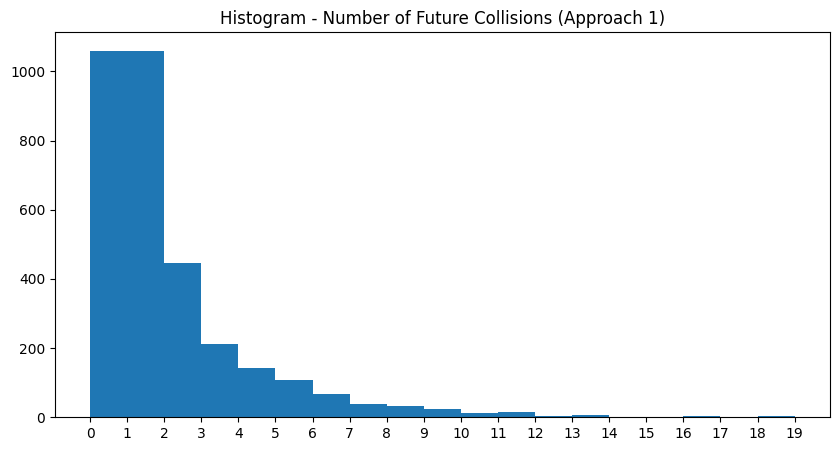

In [10]:
fig, ax = plt.subplots(figsize =(10, 5))
labels = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
ax.hist(sample['Collisions_Future'], bins = labels)
ax.set_xticks(labels)
plt.title('Histogram - Number of Future Collisions (Approach 1)')
 
# Show plot
plt.show()

In [11]:
sample.to_csv('./Data/Tiles_no_binning_downsampled.csv', index = False) 

**Balanced Set 2: Binning future collisions**

In [17]:
bin = []
for i in tiles['Collisions_Future']:
    if i == 0: 
        b = 0
    elif (i >=1 and i<=4):
        b = 1
    elif (i >=5 and i<=8):
        b = 2
    else:
        b = 3
    # elif (i == 1) or (i == 2):
    #     b = 1 
    # elif (i == 3) or (i == 4):
    #     b = 2 # 1
    # elif (i == 5) or (i == 6):
    #     b = 3 # 2 
    # elif (i == 7) or (i == 8):
    #     b = 4 # 2
    # elif (i == 9) or (i == 10):
    #     b = 5 # 2
    # else:
    #     b = 6 # 3
    # elif (i == 11) or (i == 12):
    #     b = 6
    # elif (i == 13) or (i == 14):
    #     b = 7
    # elif (i == 15) or (i == 16):
    #     b = 8
    # elif (i == 17) or (i == 18):
    #     b = 9
    # elif (i == 19) or (i == 20):
    #     b = 10
    # else: 
    #     b = 11
    bin.append(b)
    
tiles2 = tiles

tiles2['bin'] = bin 

tiles2.head(5)

,Tile_ID,Long2,Lat2,Long1,Lat1,Mid_lat,Mid_long,Stop_Signs,Paving_historical,Paving_future,Bus_stop,Collisions_Future,Collisions_Historical,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U,bin
0,36,-122.514446,37.779636,-122.513306,37.778732,37.779184,-122.513876,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0
1,37,-122.514446,37.778732,-122.513306,37.777829,37.778280,-122.513876,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0
2,151,-122.513306,37.779636,-122.512166,37.778732,37.779184,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0
3,152,-122.513306,37.778732,-122.512166,37.777829,37.778280,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0
4,153,-122.513306,37.777829,-122.512166,37.776925,37.777377,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0


In [19]:
tiles2['bin'].value_counts()

0    8290
1    1860
2     249
3      72
Name: bin, dtype: int64

In [20]:
tiles2

,Tile_ID,Long2,Lat2,Long1,Lat1,Mid_lat,Mid_long,Stop_Signs,Paving_historical,Paving_future,Bus_stop,Collisions_Future,Collisions_Historical,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U,bin
0,36,-122.514446,37.779636,-122.513306,37.778732,37.779184,-122.513876,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0
1,37,-122.514446,37.778732,-122.513306,37.777829,37.778280,-122.513876,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0
2,151,-122.513306,37.779636,-122.512166,37.778732,37.779184,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0
3,152,-122.513306,37.778732,-122.512166,37.777829,37.778280,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0
4,153,-122.513306,37.777829,-122.512166,37.776925,37.777377,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10466,15733,-122.359390,37.728130,-122.358250,37.727227,37.727679,-122.358820,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0
10467,15734,-122.359390,37.727227,-122.358250,37.726323,37.726775,-122.358820,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0
10468,15735,-122.359390,37.726323,-122.358250,37.725420,37.725871,-122.358820,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0
10469,15848,-122.358250,37.728130,-122.357110,37.727227,37.727679,-122.357680,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0


In [21]:
tiles2['bin'].value_counts()

0    8290
1    1860
2     249
3      72
Name: bin, dtype: int64

In [22]:
tiles2.to_csv('./Data/Tiles_binned.csv', index = False) 